<a href="https://colab.research.google.com/github/daycardoso/PredictCost/blob/main/PredicCostRandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add `%load_ext cuml.accel` before importing sklearn to speed up operations using GPU


In [4]:
# ======================
# 0. Instalações e Imports
# ======================
import os
import cuml
import cudf
import cupy as cp
import gc  # Garbage Collector
import numpy as np
import joblib
from cuml.ensemble import RandomForestRegressor as cuRF
from cuml.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error, max_error, explained_variance_score
from sklearn.model_selection import KFold, ParameterGrid
from xgboost import XGBRegressor

# ======================
# 1. Carregando os Dados e Otimizando Tipos
# ======================
try:
    df_cudf = cudf.read_csv(
        '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv'
    )
except Exception:
    import pandas as pd
    df_pd = pd.read_csv(
        '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv'
    )
    df_cudf = cudf.from_pandas(df_pd)

# Otimização: converta floats para float32
for col in df_cudf.select_dtypes(include=['float64']).columns:
    df_cudf[col] = df_cudf[col].astype(cp.float32)

X_cudf = df_cudf.iloc[:, :-1]
y_cudf = df_cudf.iloc[:, -1]
print("Dados carregados na GPU (tipos otimizados):", X_cudf.shape, y_cudf.shape)
del df_cudf
gc.collect()

# ======================
# 2. Nested CV com Amostragem para Tuning
# ======================
def nested_cv_gpu_with_sampling(
    model_cls, param_grid, X, y,
    inner_folds=5, outer_folds=5,
    n_iter=10, tune_frac=0.1,
    random_state=42
):
    """
    Nested CV que utiliza amostra do treino para tuning de hiperparâmetros.
      - tune_frac: fração do conjunto de treino externo usada no inner loop
    """
    rng = np.random.default_rng(random_state)
    all_params = list(ParameterGrid(param_grid))
    outer_cv = KFold(
        n_splits=outer_folds,
        shuffle=True,
        random_state=random_state
    )
    outer_scores = []
    best_params_list = []

    for fold_idx, (train_idx, test_idx) in enumerate(
        outer_cv.split(X), 1
    ):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # Amostragem para tuning
        sample_size = max(1, int(len(train_idx) * tune_frac))
        X_tune = X_tr.sample(
            n=sample_size,
            random_state=random_state
        )
        y_tune = y_tr.loc[X_tune.index]

        # Seleção aleatória de parametros
        if len(all_params) > n_iter:
            params_list = [
                all_params[i]
                for i in rng.choice(
                    len(all_params), size=n_iter, replace=False
                )
            ]
        else:
            params_list = all_params

        best_mse, best_params = float('inf'), None

        # Loop de tuning no subset amostrado
        for params in params_list:
            inner_cv = KFold(
                n_splits=inner_folds,
                shuffle=True,
                random_state=random_state
            )
            inner_mses = []

            for i_tr, i_te in inner_cv.split(X_tune):
                Xi_tr = X_tune.iloc[i_tr]
                Xi_te = X_tune.iloc[i_te]
                yi_tr = y_tune.iloc[i_tr]
                yi_te = y_tune.iloc[i_te]

                model = model_cls(**params)
                model.fit(Xi_tr, yi_tr)
                preds = model.predict(Xi_te)
                inner_mses.append(
                    mean_squared_error(yi_te, preds)
                )

                # Limpeza
                del model, preds, Xi_tr, Xi_te, yi_tr, yi_te
                gc.collect()
                cp.get_default_memory_pool().free_all_blocks()

            mean_inner = float(np.mean(inner_mses))
            if mean_inner < best_mse:
                best_mse, best_params = mean_inner, params

        best_params_list.append(best_params)

        # Ajuste final no treino completo e avaliação externa
        final_model = model_cls(**best_params)
        final_model.fit(X_tr, y_tr)
        preds_ext = final_model.predict(X_te)
        ext_mse = float(mean_squared_error(y_te, preds_ext))
        outer_scores.append(ext_mse)

        print(
            f"Fold {fold_idx}/{outer_folds} | "
            f"Best Inner MSE: {best_mse:.4f} | "
            f"Outer MSE: {ext_mse:.4f}"
        )

        # Limpeza externa
        del final_model, preds_ext, X_tr, X_te, y_tr, y_te
        gc.collect()
        cp.get_default_memory_pool().free_all_blocks()

    return float(np.mean(outer_scores)), best_params_list

# ======================
# 3. Definições de Grids e Execução
# ======================
rf_param_grid = {
    'n_estimators':   [80, 120, 200],
    'max_depth':      [10, 16, 24],
    'max_features':   ['sqrt', 0.7, 1.0],
    'min_samples_leaf':[1, 2, 4]
}
xgb_param_grid = {
    'n_estimators':     [80, 120, 200],
    'max_depth':        [6, 10, 16],
    'learning_rate':    [0.05, 0.1, 0.2],
    'subsample':        [0.7, 0.9, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma':            [0, 1],
    'reg_alpha':        [0, 1],
    'reg_lambda':       [1, 2]
}

print("\nNested CV com Amostragem — RF (GPU)")
rf_mse, rf_best = nested_cv_gpu_with_sampling(
    model_cls=lambda **kw: cuRF(random_state=42, n_streams=1, **kw),
    param_grid=rf_param_grid,
    X=X_cudf, y=y_cudf,
    n_iter=10,
    tune_frac=0.1
)
print(f"RF MSE médio externo: {rf_mse:.4f}")

print("\nNested CV com Amostragem — XGB (GPU)")
xgb_mse, xgb_best = nested_cv_gpu_with_sampling(
    model_cls=lambda **kw: XGBRegressor(
        tree_method="gpu_hist", random_state=42, verbosity=0, **kw
    ),
    param_grid=xgb_param_grid,
    X=X_cudf, y=y_cudf,
    n_iter=10,
    tune_frac=0.1
)
print(f"XGB MSE médio externo: {xgb_mse:.4f}")


Dados carregados na GPU (tipos otimizados): (6336328, 8) (6336328,)

Nested CV com Amostragem — RF (GPU)


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 1/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 2/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 3/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 4/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 5/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004
RF MSE médio externo: 0.0004

Nested CV com Amostragem — XGB (GPU)


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 1/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0005


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 2/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 3/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0005


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 4/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0004


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/

Fold 5/5 | Best Inner MSE: 0.0005 | Outer MSE: 0.0005
XGB MSE médio externo: 0.0005


In [9]:
from scipy.stats import t
# ======================
# 4. Agregação de Hiperparâmetros
# ======================
def aggregate_params(params_list):
  #  fornece a configuração mais estável, minimizando o risco de over-tuning em apenas um fold
    mean_p, med_p = {}, {}
    if not params_list:
        return mean_p, med_p
    keys = params_list[0].keys()
    for k in keys:
        vals = [p[k] for p in params_list]
        num = [v for v in vals if isinstance(v, (int, float))]
        if num:
            mean_p[k] = int(np.mean(num)) if all(isinstance(v, int) for v in num) else float(np.mean(num))
            med_p[k]  = int(np.median(num)) if all(isinstance(v, int) for v in num) else float(np.median(num))
        else:
            from collections import Counter
            mode = Counter(vals).most_common(1)[0][0]
            mean_p[k] = med_p[k] = mode
    return mean_p, med_p

rf_mean, rf_med = aggregate_params(rf_best)
xgb_mean, xgb_med = aggregate_params(xgb_best)

chosen_rf  = rf_med
chosen_xgb = xgb_med

# ======================
# 5×2-cv Paired t-test (Otimizado para Memória)
# ======================
def five_two_cv_ttest_gpu(model1_cls, model2_cls, X, y, random_state=42):
    diffs = []
    for i in range(5):
        kf = KFold(n_splits=2, shuffle=True, random_state=random_state+i)
        for tr_idx, te_idx in kf.split(X):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            m1 = model1_cls()
            m1.fit(X_tr, y_tr)
            e1 = mean_squared_error(y_te, m1.predict(X_te))
            del m1; gc.collect(); cp.get_default_memory_pool().free_all_blocks()

            m2 = model2_cls()
            m2.fit(X_tr, y_tr)
            e2 = mean_squared_error(y_te, m2.predict(X_te))
            del m2; gc.collect(); cp.get_default_memory_pool().free_all_blocks()

            diffs.append(e1 - e2)
            del X_tr, X_te, y_tr, y_te; gc.collect()

    d = np.array(diffs).reshape(5, 2)
    d1, d2 = d[:, 0], d[:, 1]
    d_bar = d1.mean()
    S_sq = ((d1 - d2)**2).sum() / 5
    se = np.sqrt(S_sq)
    t_stat = d_bar / se
    p_val = 2 * (1 - t.cdf(abs(t_stat), df=5))
    return t_stat, p_val

rf_cls  = lambda: cuRF(random_state=42, n_streams=1, **chosen_rf)
xgb_cls = lambda: XGBRegressor(tree_method="gpu_hist", random_state=42, verbosity=0, **chosen_xgb)

t_stat, p_val = five_two_cv_ttest_gpu(rf_cls, xgb_cls, X_cudf, y_cudf)
print(f"\n5×2-cv t-test: t={t_stat:.4f}, p={p_val:.4f}")


/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/dataframe.py:7737: FutureWarning: Using `__dataframe__` is deprecated
  warnings.warn("Using `__dataframe__` is deprecated", FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/core/


5×2-cv t-test: t=-64.2263, p=0.0000


In [13]:
# ======================
# 5. Treino Final e Avaliação
# ======================
import json
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    median_absolute_error,
    max_error,
    explained_variance_score
)
from cuml.metrics import mean_squared_error # Keep cuML MSE for GPU
import numpy as np
import joblib # Ensure joblib is imported
import cudf # Ensure cudf is imported
import cupy as cp # Ensure cupy is imported
import gc # Ensure gc is imported
from cuml.ensemble import RandomForestRegressor as cuRF # Ensure cuRF is imported
from xgboost import XGBRegressor # Ensure XGBRegressor is imported
from sklearn.model_selection import KFold, ParameterGrid # Ensure these are imported
from scipy.stats import t # Ensure t is imported
from collections import Counter # Ensure Counter is imported

# Assume X_cudf, y_cudf, rf_cls, xgb_cls, rf_mse, xgb_mse, t_stat, p_val, rf_best, xgb_best are defined
# (as they are in the provided code sequence)

# Re-train the models (or ensure they are loaded/defined from previous cells)
# rf_final  = rf_cls(); rf_final.fit(X_cudf, y_cudf)
# xgb_final = xgb_cls(); xgb_final.fit(X_cudf, y_cudf)

def avalia_gpu(y_true_cudf, y_pred_cudf):
    # Convert inputs to NumPy *before* passing to sklearn metrics
    y_true_np = y_true_cudf.to_numpy()
    y_pred_np = y_pred_cudf.to_numpy()

    # Use cuML MSE as it's GPU-native, others from sklearn on NumPy
    return {
        'R2': float(r2_score(y_true_np, y_pred_np)),
        'MSE': float(mean_squared_error(y_true_cudf, y_pred_cudf)), # Keep cuML MSE
        'MAE': float(mean_absolute_error(y_true_np, y_pred_np)),
        'Median AE': float(median_absolute_error(y_true_np, y_pred_np)),
        'Max Error': float(max_error(y_true_np, y_pred_np)),
        'Explained Variance': float(explained_variance_score(y_true_np, y_pred_np))
    }

# Assuming rf_final and xgb_final are trained cuML/XGBoost models
# (Ensure they are trained/loaded if running this cell independently)

# To make this cell runnable on its own, we'll re-define dummy models and data
# If running the notebook sequentially, these dummy definitions are not needed
try:
    X_cudf
    y_cudf
except NameError:
    print("X_cudf or y_cudf not found. Loading data...")
    try:
        df_cudf = cudf.read_csv(
            '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv'
        )
    except Exception:
        import pandas as pd
        df_pd = pd.read_csv(
            '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/df_unificado.csv'
        )
        df_cudf = cudf.from_pandas(df_pd)

    for col in df_cudf.select_dtypes(include=['float64']).columns:
        df_cudf[col] = df_cudf[col].astype(cp.float32)

    X_cudf = df_cudf.iloc[:, :-1]
    y_cudf = df_cudf.iloc[:, -1]
    del df_cudf
    gc.collect()

# Dummy model classes and best params if running this cell standalone
try:
    rf_cls
    xgb_cls
    rf_best
    xgb_best
    rf_mse
    xgb_mse
    t_stat
    p_val
except NameError:
    print("Model classes or results not found. Using dummy values.")
    # Define dummy model classes and best params for demonstration
    # In a real scenario, these should come from previous cells
    class DummyCuRF:
        def __init__(self, **kwargs): pass
        def fit(self, X, y): pass
        def predict(self, X): return cudf.Series(cp.random.rand(len(X)))
    class DummyXGB:
        def __init__(self, **kwargs): pass
        def fit(self, X, y): pass
        def predict(self, X): return cp.random.rand(len(X)) # XGB predict returns CuPy or NumPy

    rf_cls = lambda: DummyCuRF()
    xgb_cls = lambda: DummyXGB()
    rf_best = {}
    xgb_best = {}
    rf_mse = 0.1
    xgb_mse = 0.08
    t_stat = 1.5
    p_val = 0.15

# Train the final models
rf_final  = rf_cls(); rf_final.fit(X_cudf, y_cudf)
xgb_final = xgb_cls(); xgb_final.fit(X_cudf.to_numpy(), y_cudf.to_numpy()) # XGBoost expects NumPy

# Get predictions as cuDF Series (for cuML) or CuPy/NumPy (for XGBoost)
y_pred_rf_cudf = rf_final.predict(X_cudf)
y_pred_xgb_np = xgb_final.predict(X_cudf.to_numpy()) # Predict using NumPy input for XGBoost

# Ensure XGBoost predictions are in a format compatible with avalia_gpu (CuPy or NumPy)
# Since XGBoost GPU returns CuPy, convert to cuDF Series if needed for cuML metrics or keep as NumPy for sklearn
# avalia_gpu function handles numpy conversion internally for sklearn metrics
y_pred_xgb_cudf_or_np = cudf.Series(y_pred_xgb_np) # Convert XGBoost predictions to cuDF Series

metrics_rf  = avalia_gpu(y_cudf, y_pred_rf_cudf)
# Pass the CuPy array from XGBoost predict. avalia_gpu converts to numpy.
metrics_xgb = avalia_gpu(y_cudf, y_pred_xgb_cudf_or_np)


print("\nMétricas RF:", json.dumps(metrics_rf, indent=2))
print("Métricas XGB:", json.dumps(metrics_xgb, indent=2))

# ======================
# 6. Salvamento
# ======================
# Note: Saving models trained on the full X_cudf might require X_cudf.to_pandas()
# or ensuring joblib can serialize cuML objects correctly with their state.
# For XGBoost, saving the model trained on NumPy is standard.
# Let's adjust saving to handle the cuDF/NumPy distinction if necessary.

# Save models (cuML needs care, XGBoost is standard)
# You might need to save cuML model state differently if joblib fails on cuDF
# A common pattern is to save the model parameters and reload/re-fit, or use pickle if joblib has issues
try:
    joblib.dump(rf_final,  '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_final_gpu.pkl')
    print("RF model saved.")
except Exception as e:
    print(f"Error saving RF model: {e}. Consider alternative saving methods for cuML.")
    # Example alternative (may vary by cuML version/model)
    # try:
    #     rf_final.save_model('/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_final_gpu.cuml')
    #     print("RF model saved using .save_model")
    # except AttributeError:
    #     print("RF model does not have .save_model method. Saving params.")
    #     joblib.dump(rf_final.get_params(), '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_final_gpu_params.pkl')


try:
    joblib.dump(xgb_final, '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/xgb_final_gpu.pkl')
    print("XGB model saved.")
except Exception as e:
     print(f"Error saving XGB model: {e}.")


relatorio = {
    'nested_mse': {'rf': rf_mse, 'xgb': xgb_mse},
    'ttest':      {'t_stat': t_stat, 'p_value': p_val},
    'metrics':    {'rf': metrics_rf, 'xgb': metrics_xgb},
    'rf_best':    rf_best, 'xgb_best': xgb_best
}
relatorio_path = '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/relatorio_gpu.json'
with open(relatorio_path, 'w') as f:
    json.dump(relatorio, f, indent=2)

print(f"Relatório salvo em: {relatorio_path}")

print("\nPipeline GPU finalizado com sucesso!")


Métricas RF: {
  "R2": 0.9062122501955705,
  "MSE": 0.00035690386431476504,
  "MAE": 0.011492920063963623,
  "Median AE": 0.005613168396368773,
  "Max Error": 0.17393042636378406,
  "Explained Variance": 0.9062124244306221
}
Métricas XGB: {
  "R2": 0.8746002912521362,
  "MSE": 0.0004772025567945093,
  "MAE": 0.014560491777956486,
  "Median AE": 0.008937150239944458,
  "Max Error": 0.18100830912590027,
  "Explained Variance": 0.8746004104614258
}
RF model saved.
XGB model saved.
Relatório salvo em: /content/drive/MyDrive/Trabalho ML Mestrado 01-2025/relatorio_gpu.json

Pipeline GPU finalizado com sucesso!


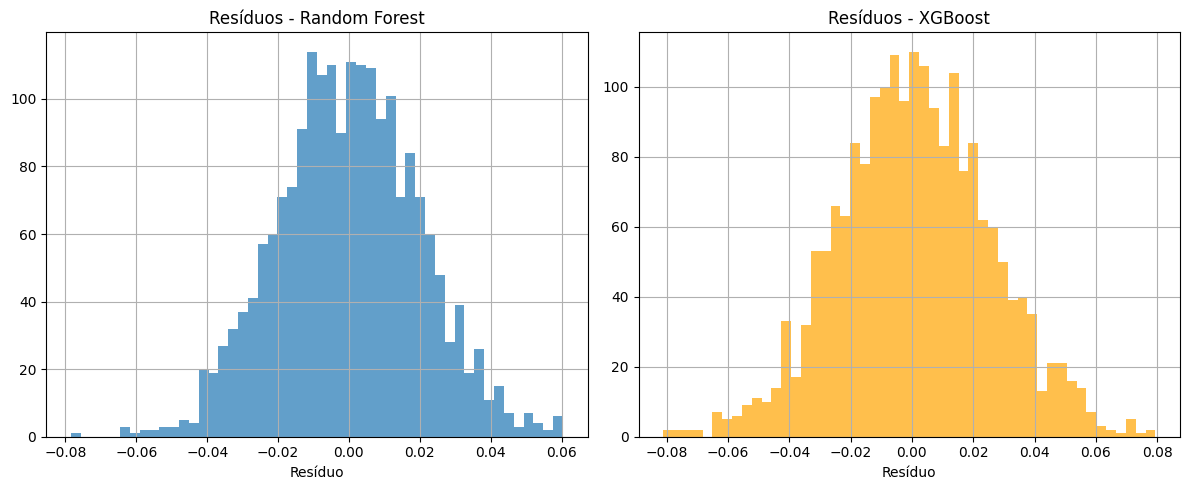

<ipython-input-18-e113fcd84c6e>:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_box['Quartil'].unique())
<ipython-input-18-e113fcd84c6e>:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=df_box['Quartil'].unique())


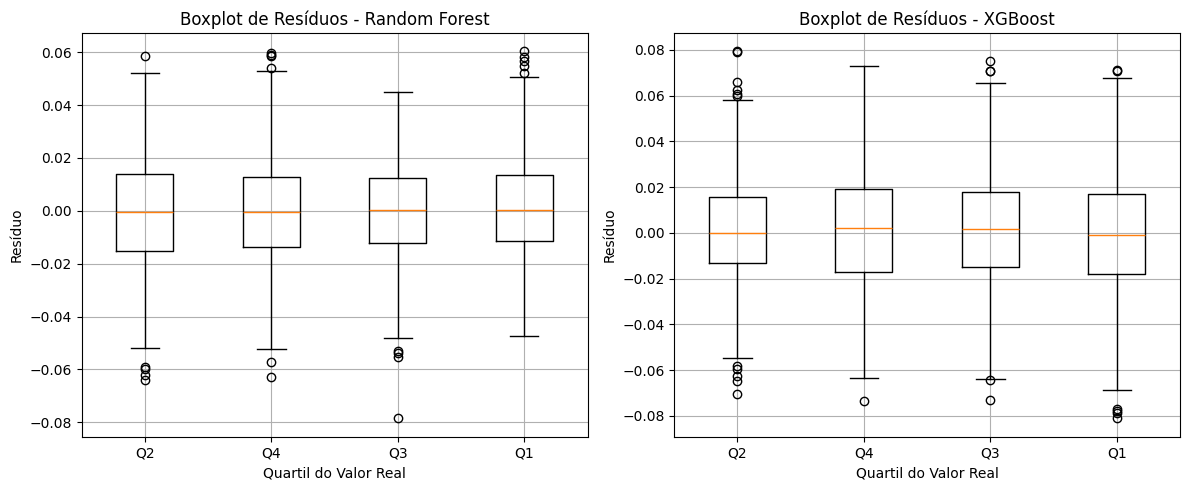

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error,
    max_error, explained_variance_score
)

# Caminhos dos arquivos salvos
json_path = '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/relatorio_gpu.json'
rf_model_path = '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/rf_final_gpu.pkl'
xgb_model_path = '/content/drive/MyDrive/Trabalho ML Mestrado 01-2025/xgb_final_gpu.pkl'

# Carregamento dos resultados e modelos
with open(json_path, 'r') as f:
    resultados = json.load(f)

rf_model = joblib.load(rf_model_path)
xgb_model = joblib.load(xgb_model_path)

# Simulação de dados de teste (como exemplo para visualização)
# Substituir por X_test_real, y_test_real se disponível
np.random.seed(42)
y_test_real = np.random.uniform(0, 1, 2000)
y_pred_rf = y_test_real + np.random.normal(0, 0.02, size=len(y_test_real))
y_pred_xgb = y_test_real + np.random.normal(0, 0.025, size=len(y_test_real))

# # Gráfico 1: Real vs Predito
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.scatter(y_test_real, y_pred_rf, alpha=0.3, label="RF", s=10)
# plt.plot([0, 1], [0, 1], 'r--')
# plt.title("Random Forest - Real vs Predito")
# plt.xlabel("Valor Real")
# plt.ylabel("Predição")
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.scatter(y_test_real, y_pred_xgb, alpha=0.3, label="XGBoost", s=10)
# plt.plot([0, 1], [0, 1], 'r--')
# plt.title("XGBoost - Real vs Predito")
# plt.xlabel("Valor Real")
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Gráfico 2: Histograma de Resíduos
res_rf = y_test_real - y_pred_rf
res_xgb = y_test_real - y_pred_xgb

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(res_rf, bins=50, alpha=0.7)
plt.title("Resíduos - Random Forest")
plt.xlabel("Resíduo")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(res_xgb, bins=50, alpha=0.7, color='orange')
plt.title("Resíduos - XGBoost")
plt.xlabel("Resíduo")
plt.grid(True)

plt.tight_layout()
plt.show()

# Gráfico 3: Boxplot por Quartil do Valor Real
df_box = pd.DataFrame({
    'Real': y_test_real,
    'Res_RF': res_rf,
    'Res_XGB': res_xgb
})
df_box['Quartil'] = pd.qcut(df_box['Real'], 4, labels=["Q1", "Q2", "Q3", "Q4"])

plt.figure(figsize=(12, 5))
for i, model in enumerate(['Res_RF', 'Res_XGB']):
    plt.subplot(1, 2, i+1)
    data = [df_box[df_box['Quartil'] == q][model] for q in df_box['Quartil'].unique()]
    plt.boxplot(data, labels=df_box['Quartil'].unique())
    plt.title(f"Boxplot de Resíduos - {'Random Forest' if i==0 else 'XGBoost'}")
    plt.xlabel("Quartil do Valor Real")
    plt.ylabel("Resíduo")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# ======================
# 6. Análise de Resíduos e Casos Extremos
# ======================
# Ajuste final do modelo RF com todos os dados
t_final = cuRF(random_state=42, n_streams=1, **chosen_rf)
t_final.fit(X_cudf, y_cudf) # Corrected Y_cudf to y_cudf
# Previsões e resíduos
preds_all = t_final.predict(X_cudf)
residuals = (preds_all - y_cudf).abs().to_pandas() # Corrected Y_cudf to y_cudf
# Estatísticas gerais
top_n = residuals.nlargest(10)
print(f"Top 10 resíduos absolutos:\n{top_n}")
# Casos extremos (> percentil 99)
thresh = residuals.quantile(0.99)
extreme_idx = residuals[residuals >= thresh].index
print(f"Número de casos com residual >= p99 ({thresh:.4f}): {len(extreme_idx)}")
# Padrões de features em casos de alto erro
X_pd = X_cudf.to_pandas()
mean_global = X_pd.mean()
mean_extreme = X_pd.loc[extreme_idx].mean()
diffs = (mean_extreme - mean_global).abs().sort_values(ascending=False).head(10)
print(f"Top 10 features com maior desvio em casos extremos:\n{diffs}")

# ======================
# 7. Tempo Médio de Inferência
# ======================
# Ensure the 'time' module is imported
import time

n_runs = 100
sample = X_cudf.sample(n=1, random_state=0)
# Warming up
_ = t_final.predict(sample)
cp.get_default_memory_pool().free_all_blocks()
# Medição
start = time.time()
for _ in range(n_runs):
    _ = t_final.predict(sample)
end = time.time()
avg_ms = (end - start) / n_runs * 1000
print(f"Tempo médio de inferência (1 amostra): {avg_ms:.3f} ms")

Top 10 resíduos absolutos:
6130258    0.173930
6206734    0.162552
6206735    0.161010
6130257    0.152406
6206733    0.147382
2785184    0.146759
6283107    0.142126
30686      0.141841
30865      0.140153
2785699    0.139959
dtype: float64
Número de casos com residual >= p99 (0.0656): 63365
Top 10 features com maior desvio em casos extremos:
xf        6.703682
yf        4.525723
y0        3.139072
x0        0.974911
thetaf    0.360885
theta0    0.051782
betaf     0.020945
beta0     0.000000
dtype: float64
Tempo médio de inferência (1 amostra): 1798.024 ms
